# Race LSTM prediction
The aim of this notebook is to train a LSTM model being able to predict speed of the runner at the next data point.

In [1]:
import glob
import os
import pandas as pd
import random
import sys
import dateutil.parser
from datetime import datetime

import numpy as np
from matplotlib import pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM
from keras.optimizers import RMSprop
from keras.utils import np_utils, normalize

from sklearn import metrics as me
from sklearn.utils import shuffle
import sklearn.linear_model as lm

%matplotlib inline

Using TensorFlow backend.


In [2]:
# Load the dataset
PATH_DATA = "../data/running/APE_running_data"

def convert(date):
    dt = dateutil.parser.parse(date).replace(tzinfo=None)
    epoch = datetime.utcfromtimestamp(0)
    delta = dt - epoch
    return delta.total_seconds()

colnames = np.array(['time', 'elevation', 'distance', 'speed'])
datasets_all = []

os.chdir(PATH_DATA)
for file in glob.glob("*.tab"):
    print("Processing {}".format(file))
    dataset = np.genfromtxt(file, skip_header=1,delimiter='\t', converters={0: convert})
    dataset[:,0] -= dataset[0,0]
    dataset = pd.DataFrame(dataset,columns=colnames)
    slope = np.array([])
    window_size_half = 8
    for j in dataset.index:
        index = np.arange(j-window_size_half+1, j+window_size_half+1)
        index = index[(index >= 0) & (index < len(dataset))]
        dataset_part = dataset.iloc[index].dropna()
        regr = lm.LinearRegression()
        regr.fit(dataset_part.distance[:,np.newaxis], np.array(dataset_part.elevation))
        slope = np.append(slope,regr.coef_)
    dataset['slope'] = slope
    if (len(dataset) > 300) == (len(dataset) < 900):
        datasets_all.append(dataset)

print('\nDataset sample')
print(datasets_all[0][:10])
print(len(datasets_all))

Processing activity_367230665.tab


/usr/local/lib/python3.6/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


Processing activity_373734948.tab
Processing activity_373735010.tab
Processing activity_373735080.tab
Processing activity_373735106.tab
Processing activity_377304158.tab
Processing activity_377304230.tab
Processing activity_379843442.tab
Processing activity_384747476.tab
Processing activity_396872154.tab
Processing activity_404227656.tab
Processing activity_404227667.tab
Processing activity_404227677.tab
Processing activity_404227695.tab
Processing activity_437398717.tab
Processing activity_437398721.tab
Processing activity_437398728.tab
Processing activity_437398739.tab
Processing activity_437398746.tab
Processing activity_437398751.tab
Processing activity_437398753.tab
Processing activity_437398761.tab
Processing activity_437398762.tab
Processing activity_437398768.tab
Processing activity_437398771.tab
Processing activity_437398778.tab
Processing activity_437398782.tab
Processing activity_437398785.tab
Processing activity_447149230.tab
Processing activity_447149239.tab
Processing act

In [3]:
# Number of points taken for each prediction
NB_POINTS = 10
# Number of races taken for the training set
NB_TRAINING =  20
# Number of races taken for the testing set
NB_TEST = 10
# Shuffle data or not ?
SHUFFLE = True
# List of features (columns of dataframe)
FEATURES = ['time', 'elevation', 'distance','speed', 'slope']

# Remove NaN values in dataset
dataset = [i.dropna() for i in datasets_all]

# Filter features
dataset = [x[FEATURES] for x in dataset]

# Shuffle the dataset
random.seed(42)
random.shuffle(dataset)

# Deep copy of the races
dataset_not_normalized = []
for race in dataset:
    dataset_not_normalized.append(race.copy())
    
# Normalization of each feature
# Min and max values for normalization are saved in order
# to normalize the data of the test set with those values

# Contains, for each feature the min and the max value of the feature of the training set
# These min and max values will be used to normalize the dataset
max_feature = dict.fromkeys(FEATURES, -sys.maxsize - 1)
min_feature = dict.fromkeys(FEATURES, sys.maxsize)
# Get the maximal and minimal values for each column of the training set
for race in range(NB_TRAINING):
    for column in FEATURES:
        max_local = np.amax(dataset[race][column])
        min_local = np.amin(dataset[race][column])
        if max_feature[column] < max_local:
            max_feature[column] = max_local
        if min_feature[column] > min_local:
            min_feature[column] = min_local
    
# Min-max normalisation
def norm_min_max(x, min_local, max_local):
    return (x - min_local) / (max_local - min_local)

# Apply the normal
for race in dataset:
    for column in FEATURES:
        race[column] = race[column].apply(norm_min_max, min_local=min_feature[column], max_local=max_feature[column])
    
seq = []
next_speed = []

# Creation of train set
for race in range(NB_TRAINING):
    print('Race={} ({} samples) (train)'.format(race, len(dataset[race])))
    seq_local = []
    next_speed_local = []
    for i in range(len(dataset[race])-(NB_POINTS+1)):
        seq_local.append(dataset[race][i:i+NB_POINTS].as_matrix())
        # The goal (speed) is not the normalized value
        next_speed_local.append(dataset_not_normalized[race][i+NB_POINTS:i+NB_POINTS+1]['speed'].as_matrix())
    seq += seq_local
    next_speed += next_speed_local
        
# Transform the data into numpy arrays 
trainX = np.array(seq)
trainY = np.array(next_speed)

# Shuffle data
if SHUFFLE:
    trainX, trainY = shuffle(trainX, trainY, random_state=42)
        
seq_test = []
next_speed_test = []
# Creation of test set
for race in range(NB_TRAINING, NB_TRAINING + NB_TEST):
    print('Race={} ({} samples) (test)'.format(race, len(dataset[race])))
    seq_test_local = []
    next_speed_test_local = []
    for i in range(len(dataset[race])-(NB_POINTS+1)):
        seq_test_local.append(dataset[race][i:i+NB_POINTS].as_matrix())
        # The goal (speed) is not the normalized value
        next_speed_test_local.append(dataset_not_normalized[race][i+NB_POINTS:i+NB_POINTS+1]['speed'].as_matrix())
    seq_test += seq_test_local
    next_speed_test += next_speed_test_local
        
# Transform the data into numpy arrays 
testX = np.array(seq_test)
testY = np.array(next_speed_test)
# Shuffle data
if SHUFFLE:
    testX, testY = shuffle(testX, testY, random_state=42)

Race=0 (735 samples) (train)
Race=1 (823 samples) (train)
Race=2 (693 samples) (train)
Race=3 (726 samples) (train)
Race=4 (833 samples) (train)
Race=5 (853 samples) (train)
Race=6 (709 samples) (train)
Race=7 (566 samples) (train)
Race=8 (583 samples) (train)
Race=9 (583 samples) (train)
Race=10 (527 samples) (train)
Race=11 (732 samples) (train)
Race=12 (734 samples) (train)
Race=13 (581 samples) (train)
Race=14 (616 samples) (train)
Race=15 (435 samples) (train)
Race=16 (773 samples) (train)
Race=17 (725 samples) (train)
Race=18 (682 samples) (train)
Race=19 (715 samples) (train)
Race=20 (605 samples) (test)
Race=21 (603 samples) (test)
Race=22 (685 samples) (test)
Race=23 (577 samples) (test)
Race=24 (595 samples) (test)
Race=25 (418 samples) (test)
Race=26 (536 samples) (test)
Race=27 (860 samples) (test)
Race=28 (655 samples) (test)
Race=29 (527 samples) (test)


In [ ]:
BATCH_SIZE = 10 
NB_EPOCHS = 100
NB_UNITS = 4

# Create and fit the LSTM network
model = Sequential()
model.add(LSTM(NB_UNITS, input_shape=(NB_POINTS, len(FEATURES))))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 4)                 128       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 133
Trainable params: 133
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(trainX, trainY, epochs=NB_EPOCHS, batch_size=BATCH_SIZE, verbose=1, 
                   validation_data=(testX, testY))

Train on 13404 samples, validate on 5951 samples
Epoch 1/100
13404/13404 [==============================] - 29s - loss: 1.0036 - val_loss: 0.1694

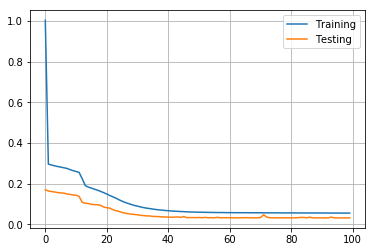

In [ ]:
# Plot the training and testing
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Testing')
plt.legend()
plt.grid()

Actual values
    distance  speed     slope
0   1.380000  2.398 -0.005980
1   1.380000  2.261  0.008163
2   4.460000  1.913  0.011956
3   9.810000  2.111  0.014740
4  13.170000  1.891  0.014677
5  17.559999  1.885  0.014280
6  19.360001  2.114  0.014118
7  22.379999  2.321  0.014391
8  35.279999  2.257  0.015162
9  48.400002  2.627  0.015852
Predictions
[[ 2.75459456]
 [ 2.67372704]
 [ 3.1200006 ]
 [ 3.49555779]
 [ 2.77475262]
 [ 3.43379855]
 [ 2.90175438]
 [ 2.96414804]
 [ 3.14942932]
 [ 3.48936605]]
Standard deviation=0.403396


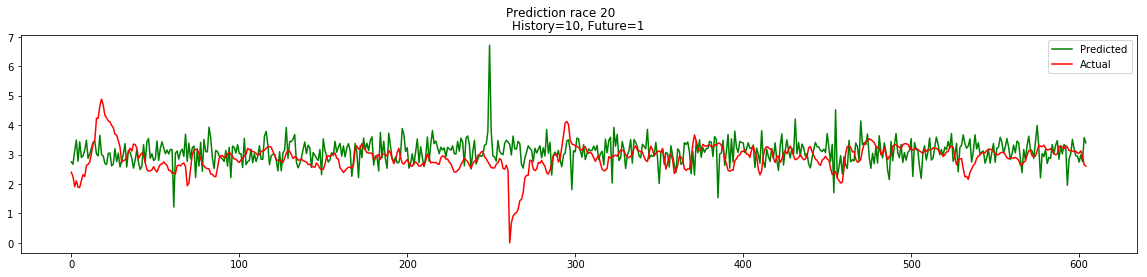

In [ ]:
# Plot one race with its prediction
RACE_NUMBER = NB_TRAINING # First race of testing set 
# Actual values
actual = dataset_not_normalized[RACE_NUMBER]
print("Actual values")
print(actual[:10])
# Predict the future values
# testX contains all the testing races, we need to extract data from the wanted race
# Calculation of starting line of test set depending on race number
start = sum(len(dataset_not_normalized[race]) for race in range(NB_TRAINING, RACE_NUMBER))
predictY = model.predict(testX[start:start + len(actual)])
print("Predictions")
print(predictY[:10])
print("Standard deviation=" + str(np.std(predictY)))

# Plot the results
plt.figure(figsize=(20,4))
plt.suptitle('Prediction race ' + str(RACE_NUMBER))
plt.title('History=' + str(NB_POINTS) + ', Future=' + str(1))

# Plot the predictions
plt.plot(np.arange(len(predictY)), predictY, 'g-', label='Predicted')
# Plot the actual values
plt.plot(np.arange(len(predictY)), actual['speed'], 'r-', label='Actual')
plt.legend()

In [ ]:
# Information about software version
%load_ext version_information
%reload_ext version_information

%version_information numpy, matplotlib, keras, pandas, sklearn, tensorflow

Software versions
Python 3.6.0 64bit [GCC 4.2.1 Compatible Apple LLVM 8.0.0 (clang-800.0.42.1)]
IPython 6.0.0
OS Darwin 16.6.0 x86_64 i386 64bit
numpy 1.12.0
matplotlib 2.0.0
keras 2.0.4
pandas 0.19.2
sklearn 0.18.1
tensorflow 1.1.0
Thu Jun 01 10:01:43 2017 CEST